# Conformal Predictions for ML Models (Dupont)

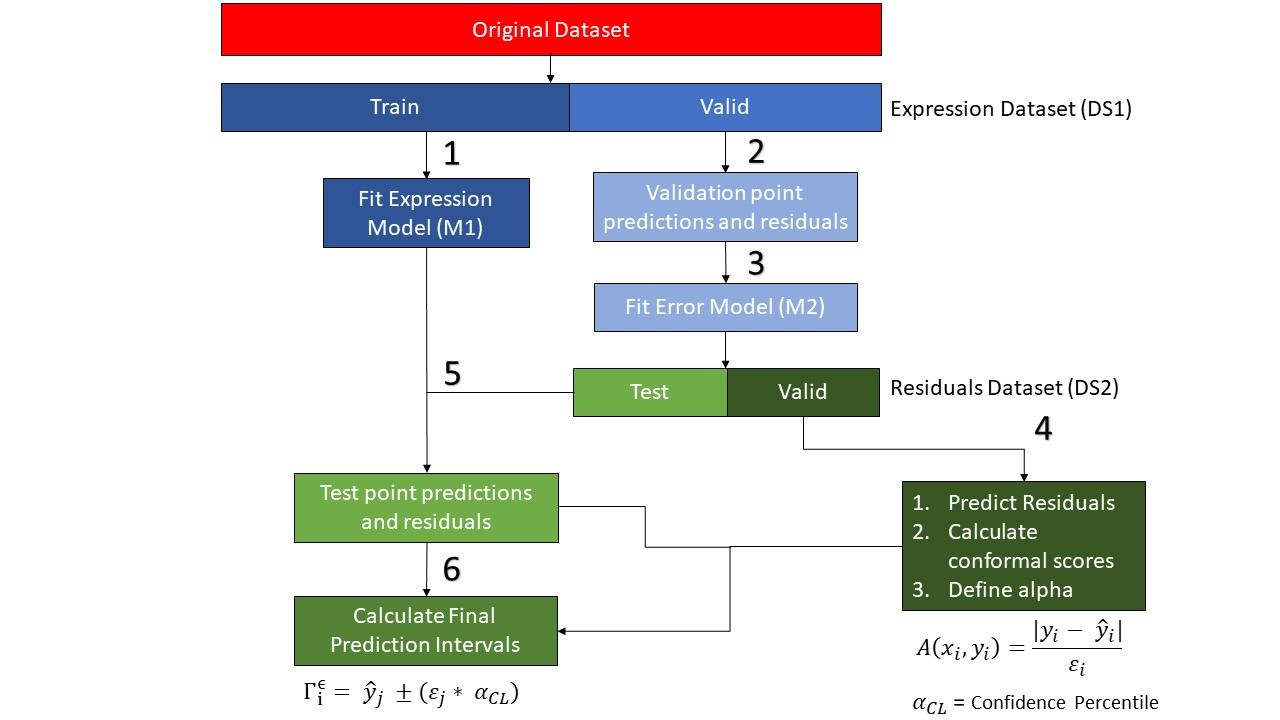

<a id='library_imports'></a>
## Library Imports

Prepare necessary modules and environments for notebook

In [1]:
#Load Modules
import dotenv
dotenv.load_dotenv(".env")
import prolerep.analysis.utils as utils
import mlflow.sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import plotnine as p9

/home/john/my_python_env/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
original_dataset = utils.read_csv_from_s3("s3://prolerep/datasets/galapagos_38.csv.gz") #Upload original dataset from MLFlow
#original_dataset

In [3]:
'Submit MLflow Model'
#!prolerep submit-experiment ./ --username JohnB --follow search_random CP_Expression "s3://prolerep/datasets/galapagos_38.csv.gz" expression --metric spearman

'Submit MLflow Model'

**Step 1:** Load Expression Dataset from MLFlow

In [4]:
expression_df = utils.read_csv_from_s3("s3://mlflow/26/7b26c72eb9a54d2886334620cbd03313/artifacts/dataset.csv") #Upload split dataset from MLFlow
expression_df.head()

,new_host,sequence,expression,split
0,False,--AQVPYGVSQIKAPALH-SQGYTGQNVKVAVIDTGIDSSHEDLKV...,0.039268,valid
1,False,--ASVPYGVSQIKAPALH-SQGYTGSNVKVAVIDSGIDSSHPDLKV...,0.039268,train
2,False,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.261457,train
3,False,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.265189,valid
4,False,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHGDLNI...,0.419681,train


**Step 2:** Seperate dataset into train and validation

In [5]:
def expression_data_split(df):
    #df = df[["sequence", "new_host", "split", "expression"]]  # rearrange dataframe columns
    train = df.loc[df["split"] == "train"]
    valid = df.loc[df["split"] == "valid"]
    # Expression Data
    x_train = train[["sequence", "new_host", "split"]]
    y_train = train[["expression"]]
    x_valid = valid[["sequence", "new_host", "split"]]
    y_valid = valid[["expression"]]
    #Convert y dataframes into arrays
    y_valid = y_valid.values
    y_train = y_train.values
    print("Data has been split")
    print("x_train and y_train shape: "+ str(x_train.shape) + str(y_train.shape))
    print("x_valid and y_valid shape: "+ str(x_valid.shape) + str(y_valid.shape))
    print('{} instances, {} features, {} classes'.format(y_train.size,
                                                   x_train.shape[1],
                                                   np.unique(y_train).size))
    return x_train, x_valid, y_train, y_valid

In [6]:
x_train, x_valid, y_train, y_valid = expression_data_split(expression_df)

Data has been split
x_train and y_train shape: (10933, 3)(10933, 1)
x_valid and y_valid shape: (7288, 3)(7288, 1)
10933 instances, 3 features, 9713 classes


**Step 3:** Load Expression_Model (Underlying Model)
* *Note: This model was previously trained to predict expression as target*

In [7]:
'Underyling Predictive Model: Target for Expression Levels'
expression_model = mlflow.sklearn.load_model("runs:/cece934af5944700ab5928922b422f20/logged_model")
#expression_model

**Step 4:** Calculate point predictions


In [8]:
valid_point_predictions = expression_model.predict(x_valid)
print("Point predictions have been estabilshed")
#valid_point_predictions

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.


Point predictions have been estabilshed


**Step 5**: Revise Expression Model Performance

In [9]:
print("R2 score : %.2f" % r2_score(y_valid, valid_point_predictions))
print("MSE score : %.2f" % mean_squared_error(y_valid, valid_point_predictions))

R2 score : 0.51
MSE score : 0.04


**Step 6:** Determine prediction errors of point predictions in calibration set

In [10]:
def calculate_residuals(predictions, true_labels):
    '''
    Calculates residuals of predicted labels vs true_labels 
    For each correct output in ``y``, nonconformity is defined as
    math::
    | y_i (predicted labels) - y^_i (true labels) |     
    
    @params
    true_labels is a numpy array of (true) labels 
    predictions is a numpy array of predicted labels
        
    Returns:
    Residual scores: numpy array of shape [n_samples]
    Residual scores of samples
    '''
    true_labels =  true_labels.flatten()
    predictions = predictions.flatten()
    residuals = np.abs(predictions - true_labels)
    
    print("Residuals have been calcualted ")
        
    return residuals

In [11]:
underlying_residuals = calculate_residuals(valid_point_predictions, y_valid)
#underlying_residuals

Residuals have been calcualted 


**Step 7:** Create new dataset (For training residuals model)

In [12]:
#task = ['residuals'] * len(x_valid)
#x_valid['task'] = task
#x_valid['output'] = underlying_residuals
#x_valid['expression'] = y_valid
#x_valid
#x_valid.to_csv(r'/home/john/Dupont_Internship/CP/CP_Residuals/dataframe_residuals_expression.csv', index = False)
#x_valid_residuals = utils.read_csv_from_s3('s3://prolerep/datasets/new_residuals_df.csv')
#x_valid_residuals

**Step 8:** Load split residuals df

In [13]:
residuals_df = utils.read_csv_from_s3("s3://mlflow/33/889162bf737e49b084acb291ba2c7415/artifacts/dataset.csv")
residuals_df

,sequence,new_host,expression,residuals,split
0,--AQVPYGVSQIKAPALH-SQGYTGQNVKVAVIDTGIDSSHEDLKV...,False,0.039268,0.796240,train
1,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,False,0.265189,0.440176,valid
2,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLNI...,False,0.145711,0.750549,valid
3,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLNI...,False,0.764063,0.928787,train
4,-AQEVPYGIPLIKADKVQ-AQGFKGANVKVAVLDTGIQASHPDLNV...,False,0.835574,0.913694,train
...,...,...,...,...,...
7283,-SQTVPWGIQRVQAPQAQ-NLGHTGSGVSVAVLDTGI-EDHPDLNV...,False,0.219801,0.196625,train
7284,-SQTVPWGISQIQAPAVH-AAGYTGTGERVAVLDTGI-APHPDLNV...,False,0.228418,0.961581,train
7285,-TQVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLNI...,False,0.263487,0.501647,train
7286,-VQVVPWGIERVQAPAAH-NRGLTGQGVKVAVLDTGI-STHEDLNI...,True,0.911805,0.436334,valid


In [14]:
def residual_data_split(residuals_df):
    cal = residuals_df.loc[residuals_df["split"] == "train"]
    test = residuals_df.loc[residuals_df["split"] == "valid"]
    # Residuals Dataset
    x_cal= cal[["sequence", "new_host", "split", "expression"]]
    y_cal = cal[["residuals"]]
    x_test = test[["sequence", "new_host", "split", "expression"]]
    y_test = test[["residuals"]]
    #Convert y dataframes into arrays
    y_test = y_test.values
    y_cal = y_cal.values
    print("Data has been split")
    print("x_cal and y_cal shape: "+ str(x_cal.shape) + str(y_cal.shape))
    print("x_test and y_test shape: "+ str(x_test.shape) + str(y_test.shape))
    print('{} instances, {} features, {} classes'.format(y_cal.size,
                                                   x_cal.shape[1],
                                                   np.unique(y_cal).size))
    return x_cal, x_test, y_cal, y_test

In [15]:
x_cal, x_test, y_cal, y_test = residual_data_split(residuals_df)

Data has been split
x_cal and y_cal shape: (5102, 4)(5102, 1)
x_test and y_test shape: (2186, 4)(2186, 1)
5102 instances, 4 features, 5100 classes


**Step 9:** Load Residual_Model
* *Note: This model was previously trained to predict residual as target*

In [16]:
'Error Model for predicting residuals'
residual_model = mlflow.sklearn.load_model("runs:/4bbfaf859e8941fd88e077e3b1f84e89/logged_model")
#residual_model

**Step 10:** Predict residuals using residual model

* *Note: These will be used to normalize the conformal scores*

In [17]:
predicted_residuals = residual_model.predict(x_cal) 
#predicted_residuals

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.


**Step 11**: Evaluate residual model performance

In [18]:
print("R2 score : %.2f" % r2_score(y_cal, predicted_residuals))
print("MSE score : %.2f" % mean_squared_error(y_cal, predicted_residuals))

R2 score : 0.28
MSE score : 0.06


**Step 12:** Obtain calibration point predictions

In [19]:
calibration_predictions = expression_model.predict(x_cal)
#calibration_predictions

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.


**Step 12:** Obtain Conformal Scores

In [20]:
def calculate_nonconformity(predictions, true_labels):
    '''
    Calculates absolute error nonconformity scores for data set.
    For each correct output in ``y``, nonconformity is defined as
    :
    | y_i (predicted labels) - y^_i (true labels) |     
    
    @params
    true_labels is a numpy array of (true) labels 
    predictions is a numpy array of predicted labels
    predicted_residuals is a numpy array of predicted_residuals (These are already flattened)
        
    Returns:
    conformal scores: numpy array of shape [n_samples]
    '''
    
    true_labels =  true_labels.flatten()
    predictions = predictions.flatten()
    conformal_scores = np.abs(true_labels - predictions)
    
    print("Conformal Scores Obtained")
        
    return conformal_scores

*Note: Need to redefine expression target from x_cal: expression*

In [21]:
expression_target = x_cal["expression"]
expression_target = expression_target.values
#expression_target

In [22]:
conformal_scores = calculate_nonconformity(calibration_predictions, expression_target)
#conformal_scores

Conformal Scores Obtained


**Step 13:** Normalize Conformal Scores

In [23]:
def normalize_scores(conformal_scores, predicted_residuals, beta):
    '''
    Normalize the conformal scores to generate tighter prediction intervals
    and reduce the size of these.
    
    @params
    conformal_scores: 
    
    Returns
    normal_scores: numpy array of shape [n_samples]
    Normalized conformal scores of the samples
    '''
    
    normalized_scores = conformal_scores / (predicted_residuals + beta)
    #normalized_scores = np.exp(normalized_scores)
    normalized_scores = normalized_scores.flatten()
    normalized_scores = np.sort(normalized_scores)[::-1] #sort in descending order
    
    return normalized_scores

In [24]:
normalized_conformal_scores = normalize_scores(conformal_scores, predicted_residuals, beta = 0.05)

**Step 14:** Get confidence percentile

In [25]:
def get_alpha_index(conformal_scores, significance):
    '''
    Determine the confidence percentile and applies the inverse of the nonconformity function
    in order to calculate the limits of the prediction intervals
    
    @params
    conformal_scores: Nonconformity scores obtained from the conformal predictor [n_calibration_samples]
    significance: Float value between 0-1 (i.e. 0.05)
        
    Returns:
        
    Interval Limits: Numpy array of shape [n_samples, 2] that determines 
    the min and max interval boundaries for each prediction interval        
    '''
    
    confidence_percentile = int(np.floor(significance * (normalized_conformal_scores.size + 1))) - 1 # Calculate the confidence percentile
    index = min(max(confidence_percentile, 0), normalized_conformal_scores.size - 1)
    alpha_percentile = normalized_conformal_scores[index]
    
    return alpha_percentile

In [26]:
#alpha_percentile = np.quantile(normalized_conformal_scores, 0.70, interpolation='lower')
alpha_percentile = get_alpha_index(normalized_conformal_scores, significance = 0.30)
#alpha_percentile

**Step 15:** Define Test Predictions and residuals using expression and residual model respectively


In [27]:
test_predictions = expression_model.predict(x_test)
predicted_test_residuals = residual_model.predict(x_test)

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.


**Step 16:** Obtain Prediction Intervals and interval size

In [28]:
def get_intervals(test_predictions, test_residuals, alpha_percentile, normalize = False):
    """
    Function will construct the prediction intervals 
    for a set of test examples. 
        
    This applies the partial inverse nonconformity function
    to each prediction from the underlying model, thus
    resulting in a prediction interval for each test pattern.

    @params
        ----------
    test_predictions: Numpy array of shape [n_samples, n_features]
    test_residuals: predicted residuals of new samples using error_mode
    alpha_percentile: confidence percentile of normalized_conformal_scores

        
    Returns
    -------
    prediction_intervals : numpy array of shape [n_samples, 2]
    Interval Size: Array that contains the size of the predicted intervals

    When significance value is a float between 0 and 1, then p 
    contains the prediction intervals (minimum and maximum boundaries)
    for the set of test patterns at the chosen significance level.
    """
    
    if normalize is True:
        lower_interval = test_predictions - (test_residuals * alpha_percentile)
        higher_interval = test_predictions + (test_residuals * alpha_percentile)
        #prediction_intervals = np.hstack((lower_interval, higher_interval))
        #interval_size = higher_interval - lower_interval #Efficiency measure
    
    else:
        lower_interval = test_predictions - alpha_percentile
        higher_interval = test_predictions + alpha_percentile
    
    prediction_intervals = np.hstack((lower_interval, higher_interval))
    interval_size = higher_interval - lower_interval #Efficiency measure

    print("Prediction Intervals Created")

    return prediction_intervals, interval_size


In [29]:
normalized_prediction_intervals, normalized_interval_size = get_intervals(test_predictions, predicted_test_residuals, alpha_percentile, normalize = True)
#static_prediction_intervals

Prediction Intervals Created


**Step 17:** Evaluate Prediction Intervals

In [30]:
def get_evaluation_table(prediction_intervals, interval_size, y_test):
    '''
    Gives a final table that contains the prediction intervals, their size
    and original (true) labels of the test patterns. 
    Allows to determine efficiency of predictions
        
    @params
    predictions: Prediction intervals determined from the test patterns
    size: Size of the respective prediction intervals
    y: array of the true labels (i.e. y_test)
        
    returns:
        
    Tabulated results for the evaluation function
    ''' 
    
    min_interval = prediction_intervals[:, 0]
    max_interval = prediction_intervals[:, 1]
    min_interval = min_interval.flatten()
    max_interval = max_interval.flatten()
    interval_size = interval_size.flatten()
    y_test = y_test.flatten()
    evaluation_table = pd.DataFrame({'min':min_interval, 'max':max_interval, 'true': y_test, 'interval_size': interval_size})
    
    return evaluation_table

*Note: Static intervals, which are not normalized*

**Step 18:** Final Tables and Visualizations

**Model Performance**

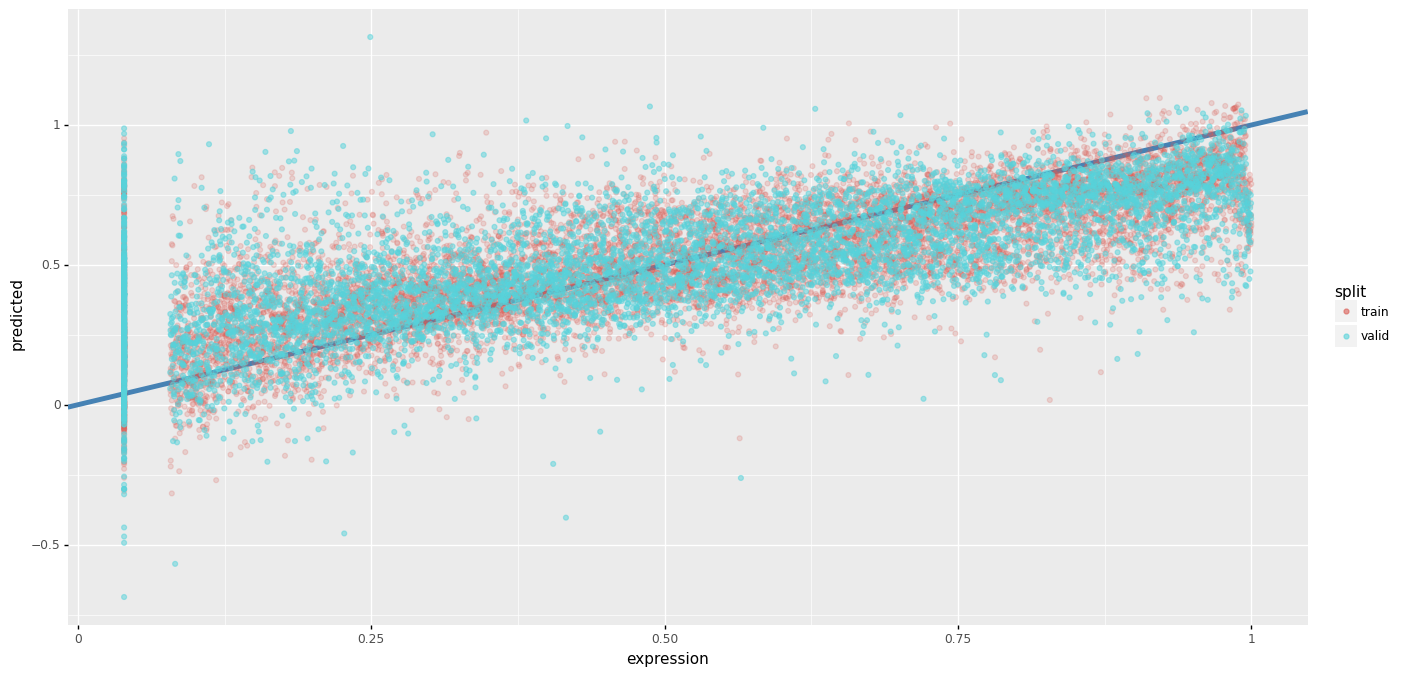

<ggplot: (8727299509317)>

In [31]:
#Expression Model Performance Overview
expression_plot_df = utils.read_csv_from_s3("s3://prolerep/datasets/expression_plot_df.csv")

p9.options.set_option("figure_size", (16, 8))
(p9.ggplot(expression_plot_df, p9.aes("expression", "predicted", color="split"))
 + p9.geom_abline(color="steelblue", size=2)
 + p9.geom_point(alpha=.2, data=expression_plot_df[expression_plot_df.split == "train"])
 + p9.geom_point(alpha=.5, data=expression_plot_df[expression_plot_df.split == "valid"])
)

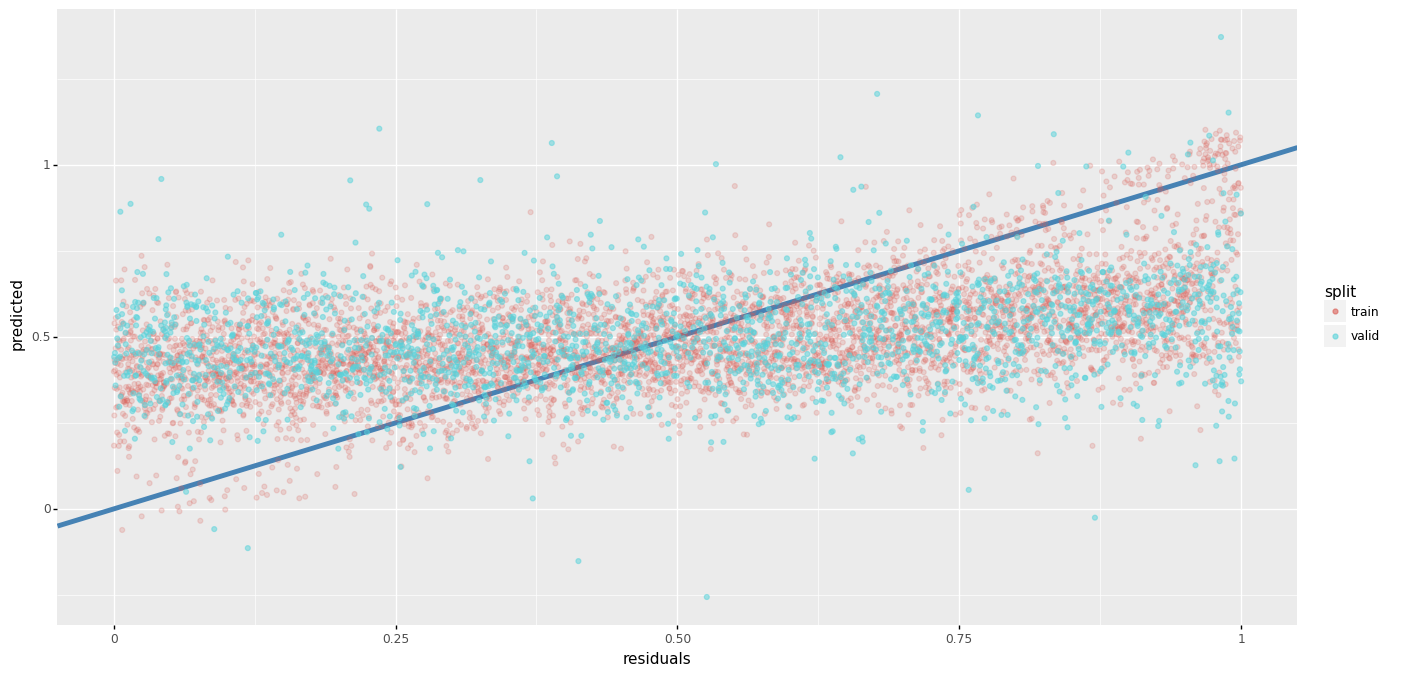

<ggplot: (8727298912993)>

In [32]:
#Residual Model Performance Overview
residuals_plot_df = utils.read_csv_from_s3("s3://prolerep/datasets/residuals_plot_df.csv")

p9.options.set_option("figure_size", (16, 8))
(p9.ggplot(residuals_plot_df, p9.aes("residuals", "predicted", color="split"))
 + p9.geom_abline(color="steelblue", size=2)
 + p9.geom_point(alpha=.2, data=residuals_plot_df[residuals_plot_df.split == "train"])
 + p9.geom_point(alpha=.5, data=residuals_plot_df[residuals_plot_df.split == "valid"])
)

**_Normalized Evaluations_**

*Min and Max Intervals with True Labels* 

In [33]:
normalized_evaluation_table = get_evaluation_table(normalized_prediction_intervals, normalized_interval_size, y_test)
#normalized_evaluation_table

In [34]:
#Sort values by "interval_size"
normalized_sorted_table = normalized_evaluation_table.sort_values("interval_size")
plot_range = list(range(0,len(normalized_sorted_table)))
normalized_sorted_table['index'] = plot_range
normalized_sorted_table

,min,max,true,interval_size,index
1795,0.588879,0.408559,0.526070,-0.180320,0
344,0.341091,0.234292,0.412184,-0.106799,1
1719,0.314548,0.234319,0.118963,-0.080229,2
2183,0.220153,0.178871,0.089188,-0.041282,3
1370,-0.078900,-0.096813,0.870335,-0.017912,4
...,...,...,...,...,...
2169,0.093804,0.872158,0.235593,0.778354,2181
695,-0.148312,0.657260,0.766603,0.805572,2182
1784,0.299364,1.110588,0.988886,0.811224,2183
2174,-0.169052,0.680517,0.677141,0.849569,2184


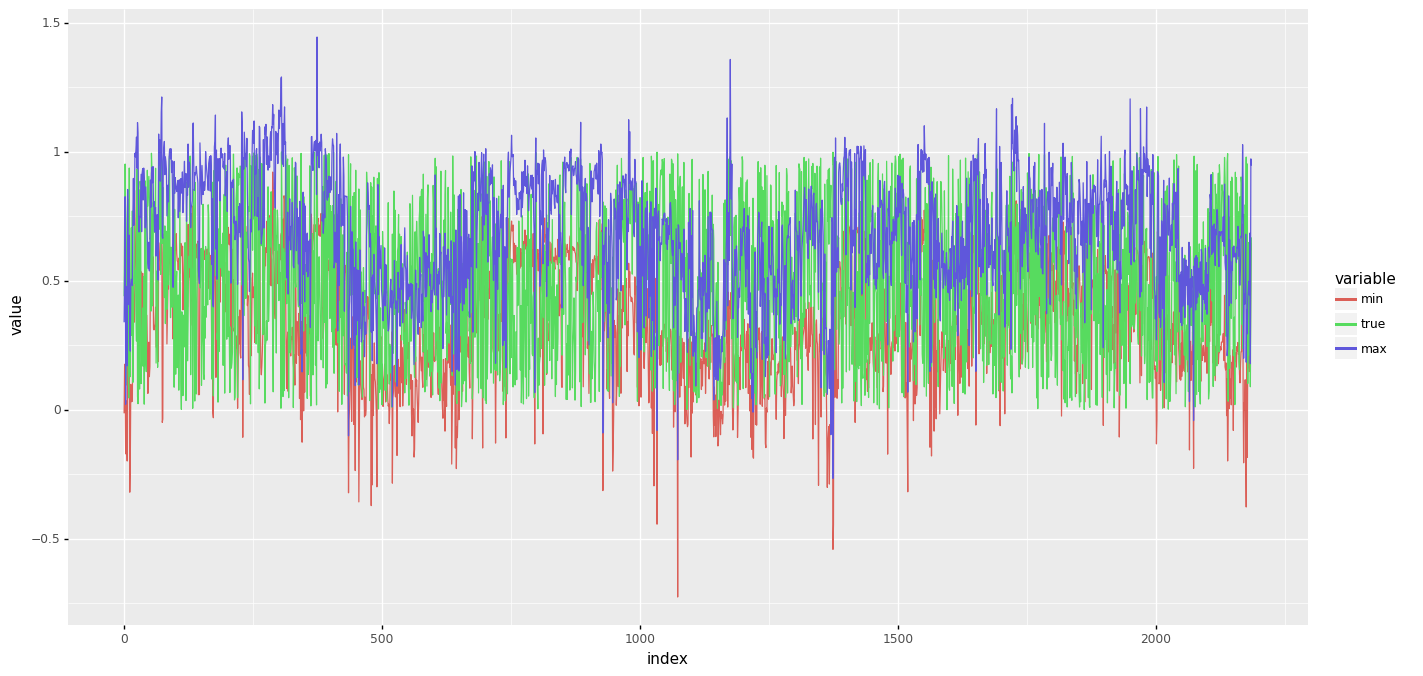

<ggplot: (8727299567013)>

In [35]:
import pandas.api.types as pdtypes
# Convert to tidy data format, making sure to keep the index
sorted_data_long = normalized_sorted_table.melt(value_vars=['min', 'true', 'max'], ignore_index=False).reset_index()
# Make variable a categorical, with categories ordered so as to make sense in the legend
sorted_data_long['variable'] = sorted_data_long['variable'].astype(pdtypes.CategoricalDtype(['min', 'true', 'max']))
# Plot
p9.options.set_option("figure_size", (16, 8))
(p9.ggplot(sorted_data_long, p9.aes('index', y='value', color='variable'))
 + p9.geom_line())

In [36]:
y_test_abs = np.abs(y_test)
interval_sizes = np.abs(normalized_evaluation_table["interval_size"].values)
residuals_vs_intervals = pd.DataFrame({'true_residuals': y_test_abs.flatten(), 'confidence_interval': interval_sizes})
##residuals_vs_intervals

*Residuals vs Interval Size* 

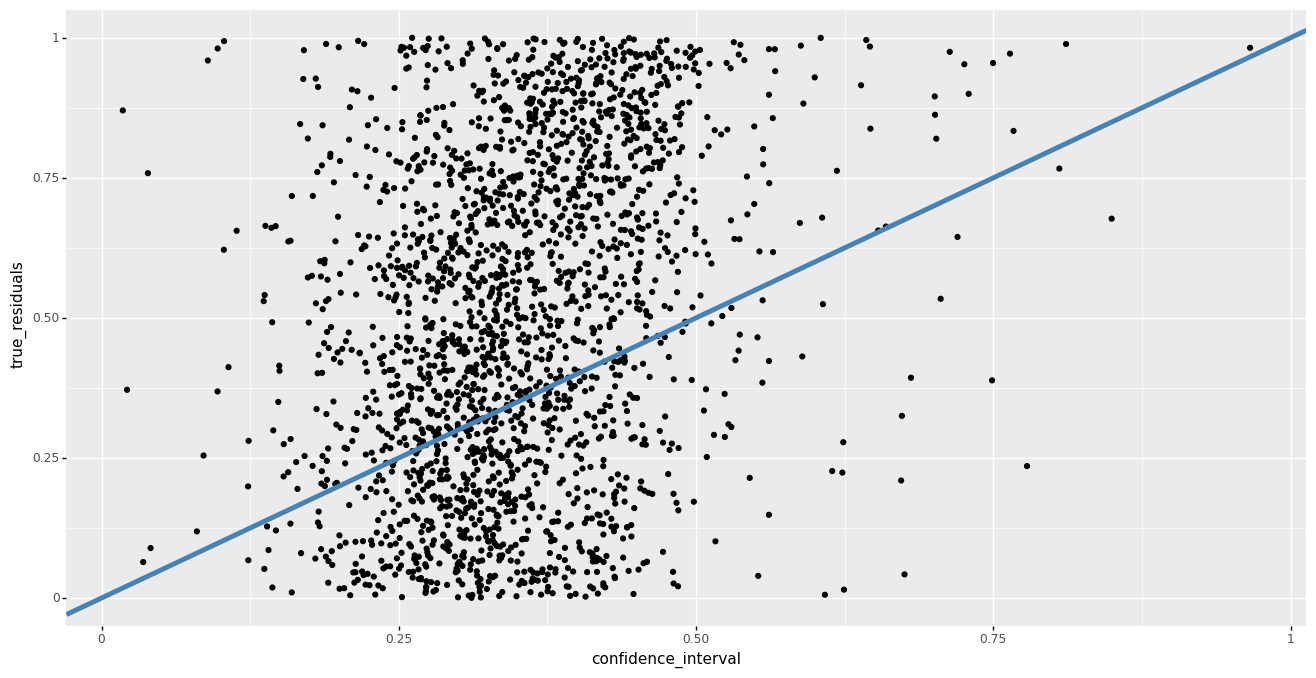

<ggplot: (8727298119285)>

In [37]:
#Just based on the test dataset
p9.options.set_option("figure_size", (16, 8))
(p9.ggplot(residuals_vs_intervals, p9.aes("confidence_interval", "true_residuals"))
 + p9.geom_point()
 + p9.geom_abline(color="steelblue", size=2)
)

**_Static Evaluations_**
* *Note: Static Evaluations are used as reference, these will always have the same interval_size*

*Min and Max Intervals with True Labels* 

In [38]:
static_prediction_intervals, static_interval_size = get_intervals(test_predictions, predicted_test_residuals, alpha_percentile, normalize = False)
static_evaluation_table = get_evaluation_table(static_prediction_intervals, static_interval_size, y_test)
#Sort values by "interval_size"
static_sorted_table = static_evaluation_table.sort_values("interval_size")
plot_range = list(range(0,len(static_sorted_table)))
static_sorted_table['index'] = plot_range
#static_sorted_table

Prediction Intervals Created


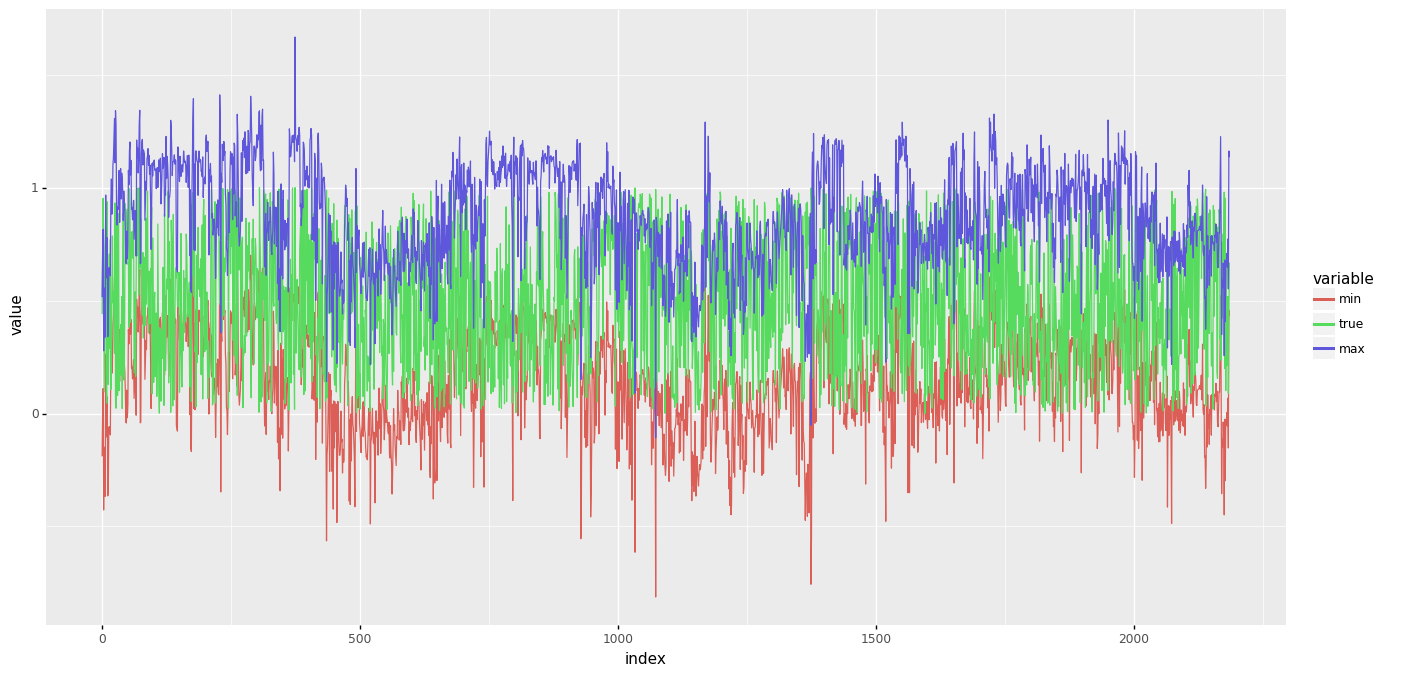

<ggplot: (8727298935605)>

In [39]:
import pandas.api.types as pdtypes
# Convert to tidy data format, making sure to keep the index
static_sorted_data_long = static_sorted_table.melt(value_vars=['min', 'true', 'max'], ignore_index=False).reset_index()
# Make variable a categorical, with categories ordered so as to make sense in the legend
static_sorted_data_long['variable'] = static_sorted_data_long['variable'].astype(pdtypes.CategoricalDtype(['min', 'true', 'max']))
# Plot
p9.options.set_option("figure_size", (16, 8))
(p9.ggplot(static_sorted_data_long, p9.aes('index', y='value', color='variable'))
 + p9.geom_line())

In [40]:
y_test_abs = np.abs(y_test)
interval_sizes = np.abs(static_evaluation_table["interval_size"].values)
residuals_vs_intervals = pd.DataFrame({'true_residuals': y_test_abs.flatten(), 'confidence_interval': interval_sizes})
##residuals_vs_intervals

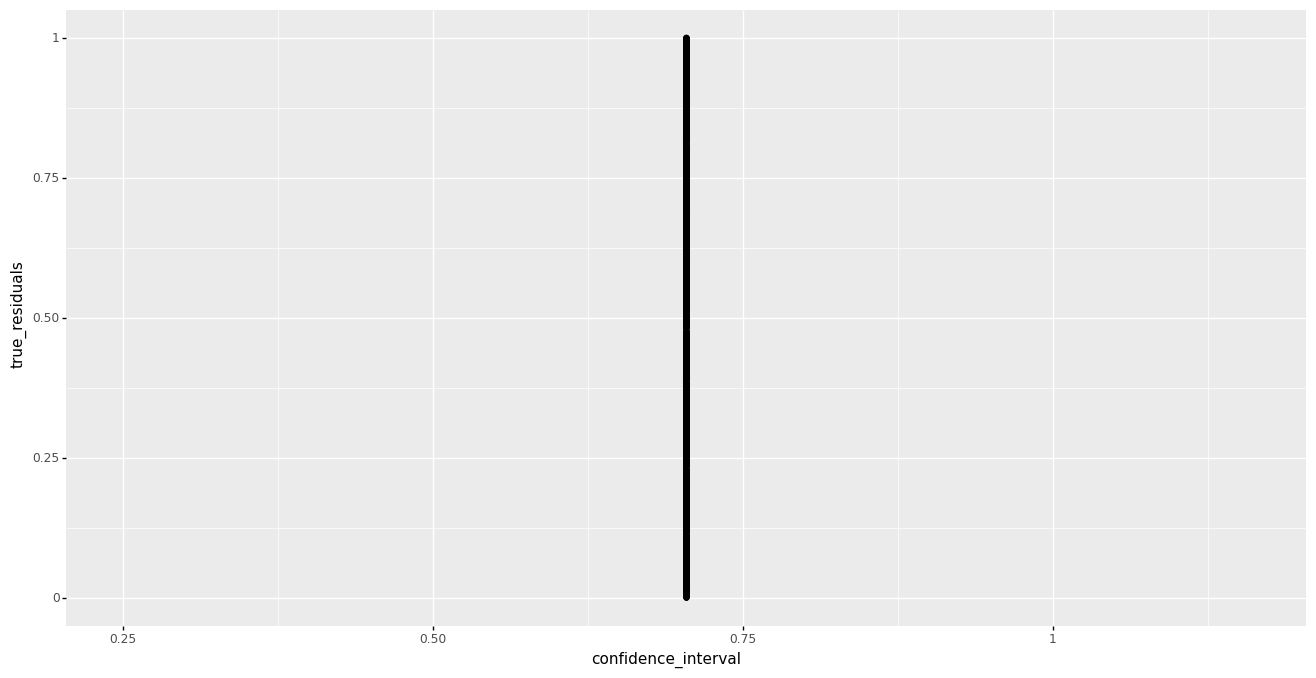

<ggplot: (8727275445749)>

In [41]:
#Just based on the test dataset
p9.options.set_option("figure_size", (16, 8))
(p9.ggplot(residuals_vs_intervals, p9.aes("confidence_interval", "true_residuals"))
 + p9.geom_point()
)